In [1]:
import torch
from torch import nn
from torch import optim
from torchvision.transforms import Normalize
import numpy as np
from PIL import Image

In [2]:
from GradCam import GradCAM

In [3]:
class Model(nn.Module):
    def __init__(self, lr):
        super().__init__()

        class Block(nn.Module):
            def __init__(this, features):
                super().__init__()
                this.num_featues = features
                this.conv1 = nn.Conv2d(in_channels=this.num_featues, out_channels=this.num_featues, kernel_size=3, padding=1)
                this.conv2 = nn.Conv2d(in_channels=this.num_featues, out_channels=this.num_featues, kernel_size=3, padding=1)
            def forward(this, x):
                y = torch.relu(this.conv1(x))
                return torch.relu(x + y)
            
            __call__ = forward

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1), # 6 x 128 x 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4), # 6 x 32 x 32
            nn.Sequential(*[Block(6) for i in range(3)]),
            nn.Conv2d(in_channels=6, out_channels=24, kernel_size=3, padding=1), # 24 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Sequential(*[Block(24) for i in range(3)])
        )

        self.avg_pool = nn.AvgPool2d(kernel_size=2) # 24 x 4 x 4

        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=24*4*4, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=2),
            nn.Sigmoid()
        )

        self.loss = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.parameters(), lr=lr, weight_decay=0.00001)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.avg_pool(x)
        x = self.linear_layers(x.reshape(-1, 24*4*4))

        return x

In [4]:
device = torch.device('cuda')
MODEL = Model(lr=0.001)
MODEL.to(device)
def LoadModel(MODEL:Model):
    MODEL.load_state_dict(torch.load("weights.pth"))


LoadModel(MODEL)

In [5]:
NORMALIZE = Normalize(
mean=(0.4883098900318146, 0.4550710618495941, 0.41694772243499756),
std =(0.25926217436790466, 0.25269168615341187, 0.25525805354118347)
)
def preprocessor(im: torch.Tensor | np.ndarray | Image.Image):
    im = Image.fromarray(np.array(im))
    im = im.convert("RGB")
    im = im.resize((128,128))
    im = NORMALIZE((torch.tensor([np.array(im)])/255.0).permute(dims=(0,3,1,2)))
    im = im.to(device)
    return im

def LoadImage(filepath:str):
    return np.array(Image.open(filepath))

In [6]:
CAM = GradCAM(Model=MODEL, LayerName='conv_layers', Normalization=NORMALIZE)

In [7]:
image_path = "custom_tests/cats_and_dogs1.png"
image = LoadImage(image_path)

output_probabilities:
tensor([0.0222, 0.9780], grad_fn=<SelectBackward0>)


/tmp/ipykernel_10350/329870519.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  im = NORMALIZE((torch.tensor([np.array(im)])/255.0).permute(dims=(0,3,1,2)))


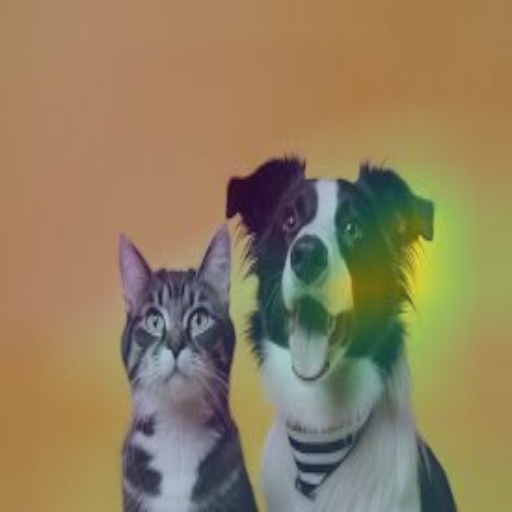

In [8]:
CAM.gradCAM_heatmapAUTOLABEL(preprocessor=preprocessor, im=image)

# CAM.showHeatMap()